In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
from architecture.session import Session, egeofno_ver1, egeofno_ver2, \
    egeofno_ver3, egeofno_ver4, svdfno_ver1, svdfno_ver2, svdfno_ver3, svdfno_ver4

######### FIX MATRIX PLOTTING TAMALE #####
N_train = 20001
data_dir = "/home/emastr/deep-micro-slip-model/data/micro_geometries_boundcurv_repar_256_torch/data_0.torch"
#save_dir = "/mnt/data0/emastr/article_training_nodecay/"
save_dir = "/mnt/data0/emastr/article_training_lowline/"
fig_dir = "/home/emastr/deep-micro-slip-model/data/"

rel error: 0.06356244534254074
rel error: 0.06510414183139801


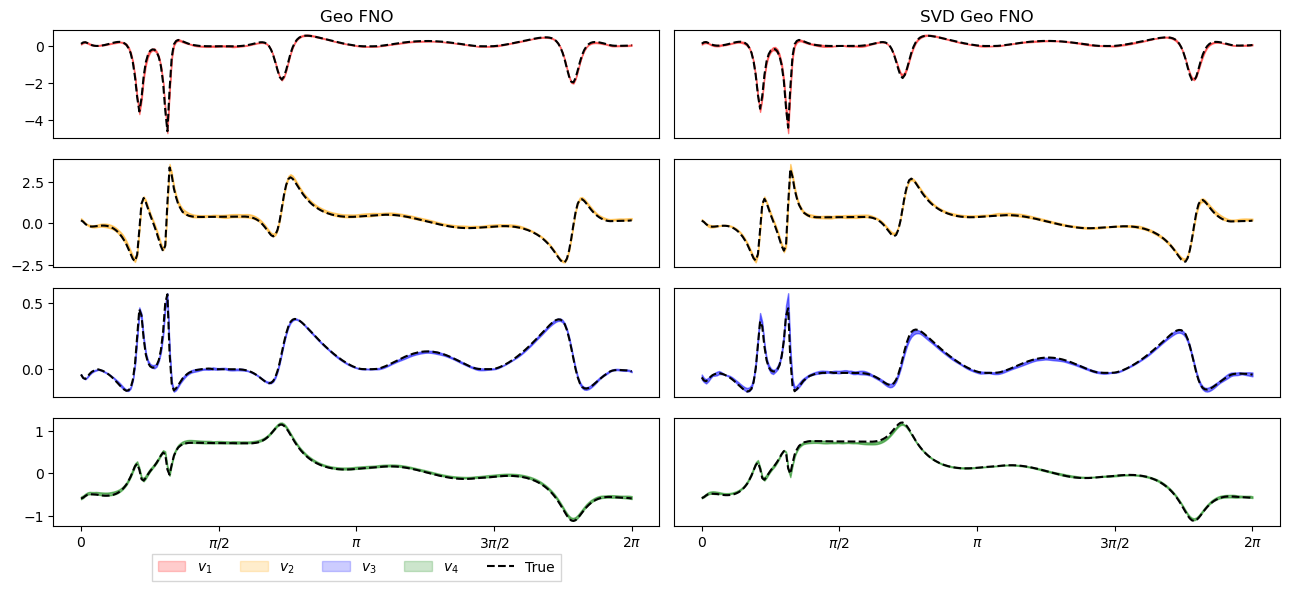

In [3]:
def plot(data, net):
        # Plot example
        (x, y) = data[338]
        xc, yc = x[None, :, :], y[None, :, :]
        f = [net(xc).squeeze().detach().cpu() for net in nets]
        x = xc.squeeze().detach().cpu()
        y = yc.squeeze().detach().cpu()
        t = np.linspace(0, 2*np.pi, x.shape[-1])
        return f, x, y, t



device = "cuda:1"
net_gens = [egeofno_ver1, egeofno_ver2, egeofno_ver3, egeofno_ver4]
net_gens = [svdfno_ver1, svdfno_ver2, svdfno_ver3, svdfno_ver4]
names = ["fno_ver2", "svdfno_ver2"]
labels = ["Geo FNO", "SVD Geo FNO"]
net_gens = [egeofno_ver2, svdfno_ver2]
#for idx in [1, 2, 3, 4]:
colors=["red", "orange", "blue", "green"]

fig = plt.figure(figsize=(13,6))
for idx, name in enumerate(names):
    idx = idx +1
    nets = []
    #plt.figure(figsize=(8,8))
    for seed in [0, 1, 2, 3, 4, 5]:#, 4, 5]:
        #save_name = f"svdfno_ver{idx}_seed{seed}"
        save_name = f"{name}_seed{seed}"
        state_dict = torch.load(f"{save_dir}{save_name}_20000.Torch")["state dict"]
        net = net_gens[idx-1](device=device)
        net.load_state_dict(state_dict)
        nets.append(net)
        
    data = Session.get_data(net, data_dir, device)
    f, x, y, t = plot(data, nets)
    
    ymean = np.max(np.abs(y.numpy()), axis=-1)
    
    print(f"rel error: {np.linalg.norm(y-f[0])/np.linalg.norm(y)}")
    
    ftot = np.array(f)
    fmax = np.max(ftot, axis=0)
    fmin = np.min(ftot, axis=0)

    for i in [1,2,3,4]:#[1,2,3,4]
        s = 1#float(1/ymean[-i])
        #s = 1/(1+(i%2))
        #print(s)
        plt.subplot(4,2,2*(i-1)+idx)
        if i == 4:
            plt.xticks([np.pi*k for k in [0, 0.5, 1, 1.5, 2]], ["0", "$\\pi/2$", "$\\pi$", "$3\\pi/2$", "$2\\pi$"])
        else:
            plt.xticks([])
        if idx == 2:
            plt.yticks([])
        plt.title(labels[idx-1] if i==1 else "")
        label="$v_1$, 6 sample CI" if i==1 else "$v_2$, 6 sample CI"
        plt.fill_between(t, fmax[-i]*s, fmin[-i]*s, color=colors[i-1], alpha=0.5)#color="red" if i==1 else "blue", alpha=0.5)
        plt.plot(t, y[-i]*s, 'k--')
        
        if i == 4:
            ylim = plt.gca().get_ylim()
            for j in range(4):
                plt.fill_between([0, np.pi*2], ylim[1]+1, ylim[1]+2, color=colors[j], label=f"$v_{j+1}$", alpha=0.2)
            plt.plot([0,1],  [(ylim[1]+0.1) for _ in [0, 1]], 'k--', label="True")
            #plt.fill_between([np.pi, 2*np.pi], ylim[1]+1, ylim[1]+2, color="gray", alpha=0.2)
            plt.ylim(ylim)
        
        if idx == 1 and i == 4:
            plt.legend(loc='upper center', bbox_to_anchor=(.5, -0.2), fancybox=False, shadow=False, ncol=5)

    
        

    #ax2 = plt.gca().twinx()  # instantiate a second axes that shares the same x-axis
    for i in []:#[1,2]:#[1,2,3,4]:
        s = 1#float(1/ymean[-i])
        #s = 1/(1+(i%2))
        abserr = np.abs(y[-i] - f[0][-i])*s
        plt.fill_between(t, 0*abserr, abserr, alpha=0.2)#, color="red" if i==1 else "blue", alpha=0.2)        

        #abserr = (fmax[-i] - fmin[-i])*s
        #ax2.fill_between(t, 0*abserr, abserr, alpha=0.2)#color="red" if i==1 else "blue", alpha=0.2)        
        
    #plt.plot(t, x[-1], label="x")
#    plt.plot(t, fmin[-1], label=f"min")
    #plt.legend(loc="upper right", frameon=False)
   
    
plt.tight_layout()
fig.savefig(f"{fig_dir}sample.pdf", bbox_inches="tight")

